In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, balanced_accuracy_score


In [3]:
##PART 1:Data Preperation

train_path = r'C:\Users\SUDE\Desktop\ie425\IE425_Spring25_train_data.csv'

train = pd.read_csv(train_path)    

print(train.isna().sum()) #to check if there are any missing values

train['sellingprice'] = train['sellingprice'].fillna(0)
train['product_gender'] = train['product_gender'].fillna('Unknown')
train['brand_id'] = train['brand_id'].fillna('unknown')
train['brand_name'] = train['brand_name'].fillna('unknown')
train['product_name'] = train['product_name'].fillna('unknown')

for col in ['user_action', 'product_gender', 'brand_id', 'brand_name', 'businessunit', 'Level1_Category_Name']:
    train[col] = train[col].astype('category')

print(train.info())
print(train.sample(3))

action_summary = train.pivot_table(
    index='unique_id',
    columns='user_action',
    aggfunc='size',
    fill_value=0
) 

time_stamp                   0
contentid                    6
user_action                  0
sellingprice             95477
product_name              5519
brand_id                  5519
brand_name                5538
businessunit              5519
product_gender          646903
category_id               5519
Level1_Category_Id        5519
Level1_Category_Name      5519
Level2_Category_Id        5519
Level2_Category_Name      5519
Level3_Category_Id        5519
Level3_Category_Name      5519
unique_id                    0
type                         0
gender                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5567027 entries, 0 to 5567026
Data columns (total 19 columns):
 #   Column                Dtype   
---  ------                -----   
 0   time_stamp            object  
 1   contentid             object  
 2   user_action           category
 3   sellingprice          float64 
 4   product_name          object  
 5   brand_id              catego

C:\Users\SUDE\AppData\Local\Temp\ipykernel_22768\2723489793.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  action_summary = train.pivot_table(


In [4]:
##PART 2:Feature Engineering

# Calculate price-related statistics for each user, including the highest selling prices, average, and total prices they have interacted with.
price_features = (
    train.groupby('unique_id')
         .agg(avg_price=('sellingprice', 'mean'),
              total_price=('sellingprice', 'sum'),
              max_price=('sellingprice', 'max'))
         .fillna(0)
)

In [5]:
#Count the frequency with which each user interacted with products that were labeled by gender to attempt to determine product gender preferences.
product_gender_counts = (
    train.groupby('unique_id')['product_gender']
         .value_counts()
         .unstack(fill_value=0)
)

product_gender_counts.columns = [f'product_gender_{col}' for col in product_gender_counts.columns]


In [6]:
#Calculate each user's brand diversity, determine the variety of different brands each user interacted with.
brand_counts = (
    train.groupby('unique_id')
         .agg(brand_variety=('brand_id', 'nunique'))
)

In [7]:
#Construct a single feature matrix through combining all engineered characteristics
user_feature_matrix = pd.concat(
    [action_summary, price_features, product_gender_counts, brand_counts],
    axis=1
).fillna(0)

In [8]:
#For supervised learning, insert the target label (gender) to make sure each user has their own label.
labels_of_users = train.groupby('unique_id')['gender'].first().reset_index()
final_dataset = pd.merge(user_feature_matrix, labels_of_users, on='unique_id')

In [9]:
#Save the final feature matrix to disk
output_path = r'train_features.csv'
final_dataset.to_csv(output_path, index=False)
print("Feature engineering completed. Output saved to:", output_path)


Feature engineering completed. Output saved to: train_features.csv


These are the the most important 10 features determined by Random Forest model
                  feature  importance
9    product_gender_Kadın    0.175069
8    product_gender_Erkek    0.122447
5               avg_price    0.097603
6             total_price    0.084906
7               max_price    0.078728
4                   visit    0.071119
12          brand_variety    0.068939
3                  search    0.062816
10  product_gender_Unisex    0.059456
1                favorite    0.051883


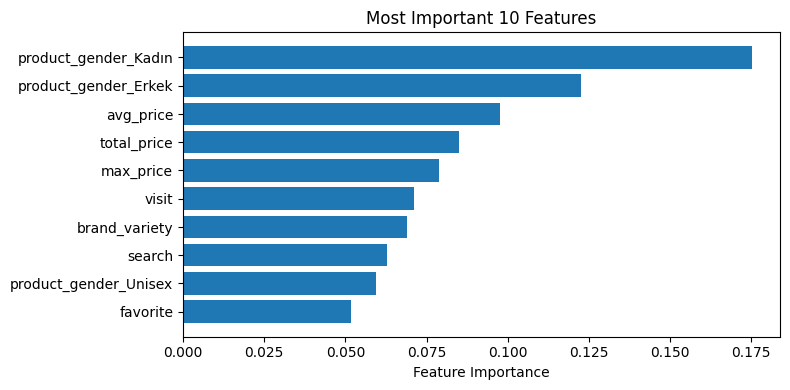

In [10]:
##PART 3:Feature Selection 

#i) Feature Selection with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_path = r'train_features.csv'
df = pd.read_csv(data_path)

# Separate features and label them
X = df.drop(columns=['unique_id', 'gender'])
y = df['gender']
 
y_encoded = y.map({'F': 1, 'M': 0})

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit a Random Forest model 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Combine and sort
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("These are the the most important 10 features determined by Random Forest model")
print(importance_df.head(10))


plt.figure(figsize=(8, 4))
plt.barh(importance_df['feature'][:10][::-1], importance_df['importance'][:10][::-1])
plt.title('Most Important 10 Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [11]:
#ii) Feature Selection with Lasso Regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('train_features.csv')

# Prepare features and label 
X = df.drop(columns=['unique_id', 'gender'])
y = df['gender'].map({'M': 0, 'F': 1})  
     

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
     

# Train/Test split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
     


# Apply Lasso Logistic Regression 
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
lasso.fit(X_train, y_train)
     
LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

# Identify selected and eliminated features 
coef = lasso.coef_[0]
selected_features = [feature for feature, weight in zip(X.columns, coef) if weight != 0]
dropped_features = [feature for feature, weight in zip(X.columns, coef) if weight == 0]
     

# results 
print(" Features selected by Lasso:")
for f in selected_features:
    print(f)

print(f"\n Features eliminated ({len(dropped_features)} features):")
print(dropped_features)

 Features selected by Lasso:
basket
favorite
order
search
visit
avg_price
max_price
product_gender_Erkek
product_gender_Kadın
product_gender_Unknown
brand_variety

 Features eliminated (2 features):
['total_price', 'product_gender_Unisex']


In [13]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pandas as pd
import numpy as np

# Load features
df = pd.read_csv("train_features.csv")
X = df.drop(columns=['unique_id', 'gender'])
y = df['gender'].map({'M': 0, 'F': 1})

# Automatically detect categorical features (non-numeric)
cat_features = X.select_dtypes(include='object').columns.tolist()

# Initialize model
cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, ber_scores = [], []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    
    cat_model.fit(train_pool)
    y_pred_proba = cat_model.predict_proba(val_pool)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    auc_scores.append(roc_auc_score(y_val, y_pred_proba))
    ber_scores.append(1 - balanced_accuracy_score(y_val, y_pred))

print(f"Mean AUC (CatBoost): {np.mean(auc_scores):.4f}")
print(f"Mean BER (CatBoost): {np.mean(ber_scores):.4f}")


Mean AUC (CatBoost): 0.8584
Mean BER (CatBoost): 0.2432


In [14]:
# Modeli tüm veride yeniden eğitiyoruz
from catboost import Pool

full_pool = Pool(X, y, cat_features=cat_features)
cat_model.fit(full_pool)

# Özellik önemleri
importances = cat_model.get_feature_importance(full_pool)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))


                   Feature  Importance
9     product_gender_Kadın   30.738002
8     product_gender_Erkek   26.514432
1                 favorite    6.780231
5                avg_price    6.361162
12           brand_variety    4.125414
2                    order    3.839269
7                max_price    3.570468
6              total_price    3.480835
11  product_gender_Unknown    3.346778
10   product_gender_Unisex    2.920118


In [17]:
import pandas as pd

test = pd.read_csv(r'C:\Users\SUDE\Desktop\425test\IE425_Spring25_test_data.csv')


In [19]:
import pandas as pd

# Load the train feature matrix (which includes the full feature structure)
train_features = pd.read_csv("train_features.csv")

# Drop target and ID to get only feature columns
expected_columns = train_features.drop(columns=['unique_id', 'gender']).columns.tolist()


In [20]:
# Drop unique_id temporarily
X_test = user_features_test.drop(columns=['unique_id'])

# Eksik kolonları sıfırla
for col in expected_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Fazla kolonları çıkar
X_test = X_test[expected_columns]

# Final test input (modelle aynı sırada ve yapıda)
print("✅ Test features aligned. Shape:", X_test.shape)


✅ Test features aligned. Shape: (2400, 13)


In [23]:
from catboost import Pool

# categorical_features değişkenini tekrar tanımlayalım (modelde kullanmıştık)
cat_features = X.select_dtypes(include='object').columns.tolist()

# CatBoost için test seti Pool formatına dönüştürülür
test_pool = Pool(data=X_test, cat_features=cat_features)


In [26]:
# Drop unique_id temporarily
X_test = user_features_test.drop(columns=['unique_id'])

# Eksik kolonları sıfırla
for col in expected_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Fazla kolonları çıkar
X_test = X_test[expected_columns]

# Final test input (modelle aynı sırada ve yapıda)
print("✅ Test features aligned. Shape:", X_test.shape)


✅ Test features aligned. Shape: (2400, 13)


In [28]:
import numpy as np

# Predict probabilities for class 1 (Female)
y_test_proba = cat_model.predict_proba(test_pool)[:, 1]

# Apply 0.5 threshold
y_test_pred = np.where(y_test_proba >= 0.5, 'F', 'M')


In [29]:
import numpy as np

# Predict probabilities for class 1 (Female)
y_test_proba = cat_model.predict_proba(test_pool)[:, 1]

# Apply 0.5 threshold
y_test_pred = np.where(y_test_proba >= 0.5, 'F', 'M')


In [36]:
import pandas as pd

# Create submission DataFrame
submission = pd.DataFrame({
    'unique_id': user_features_test['unique_id'],
    'probability_female': y_test_proba,  # from model.predict_proba()[:, 1]
    'gender': y_test_pred                # predicted class labels: 'F' or 'M'
})

# Save to CSV
submission.to_csv(r'C:\Users\SUDE\Desktop\ie425\test_prediction.csv', index=False)
print("Submission file saved")



Submission file saved


In [2]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import pandas as pd
import numpy as np

# Load training data
df = pd.read_csv("train_features.csv")
X = df.drop(columns=['unique_id', 'gender'])
y = df['gender'].map({'M': 0, 'F': 1})

# Detect categorical features
cat_features = X.select_dtypes(include='object').columns.tolist()

# Optimized model parameters
model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=4,
    random_strength=1,
    border_count=64,
    auto_class_weights='Balanced',
    cat_features=cat_features,
    eval_metric='AUC',
    verbose=0,
    random_seed=42
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
ber_scores = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    model.fit(train_pool)
    y_proba = model.predict_proba(val_pool)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc_scores.append(roc_auc_score(y_val, y_proba))
    ber_scores.append(1 - balanced_accuracy_score(y_val, y_pred))

print(f" Mean AUC: {np.mean(auc_scores):.4f}")
print(f" Mean BER: {np.mean(ber_scores):.4f}")




✅ Mean AUC: 0.8550
📉 Mean BER: 0.2205


In [4]:
import pandas as pd

test = pd.read_csv(r'C:\Users\SUDE\Desktop\425test\IE425_Spring25_test_data.csv')

# Fill missing values and typecast
test['sellingprice'] = test['sellingprice'].fillna(0)
test['product_gender'] = test['product_gender'].fillna('Unknown')
test['brand_id'] = test['brand_id'].fillna('unknown')
test['brand_name'] = test['brand_name'].fillna('unknown')
test['product_name'] = test['product_name'].fillna('unknown')

# Cast to category for known columns
for col in ['user_action', 'product_gender', 'brand_id', 'brand_name', 'businessunit', 'Level1_Category_Name']:
    test[col] = test[col].astype('category')


In [5]:
# Action summary
action_summary = test.pivot_table(
    index='unique_id', columns='user_action', aggfunc='size', fill_value=0
)

# Price features
price_features = test.groupby('unique_id').agg(
    avg_price=('sellingprice', 'mean'),
    total_price=('sellingprice', 'sum'),
    max_price=('sellingprice', 'max')
)

# Product gender count
product_gender_counts = (
    test.groupby('unique_id')['product_gender']
    .value_counts()
    .unstack(fill_value=0)
)
product_gender_counts.columns = [f'product_gender_{col}' for col in product_gender_counts.columns]

# Brand variety
brand_counts = test.groupby('unique_id').agg(
    brand_variety=('brand_id', 'nunique')
)

# Combine into feature matrix
user_features_test = pd.concat(
    [action_summary, price_features, product_gender_counts, brand_counts],
    axis=1
).fillna(0)

# Save unique_id separately
test_ids = user_features_test.index


C:\Users\SUDE\AppData\Local\Temp\ipykernel_23700\3405751036.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  action_summary = test.pivot_table(


In [6]:
# Predict probabilities
test_proba = model.predict_proba(user_features_test)[:, 1]

# Predict labels
test_pred = np.where(test_proba >= 0.5, 'F', 'M')

# Create submission dataframe
submission = pd.DataFrame({
    'unique_id': test_ids,
    'probability_female': test_proba,
    'gender': test_pred
})

# Save to file
submission.to_csv(r'C:\Users\SUDE\Desktop\ie425\test_prediction.csv', index=False)
print("Submission file saved")




Submission file saved


In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

# Load data
df = pd.read_csv("train_features.csv")
X = df.drop(columns=['unique_id', 'gender'])
y = df['gender'].map({'M': 0, 'F': 1})

# Detect categorical columns for CatBoost
cat_features = X.select_dtypes(include='object').columns.tolist()

# Prepare ElasticNet
X_scaled = X.copy()
X_scaled[cat_features] = X_scaled[cat_features].astype(str)
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_scaled.select_dtypes(include=np.number)),
    columns=X.select_dtypes(include=np.number).columns
)

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cat_preds = np.zeros(len(X))
enet_preds = np.zeros(len(X))

for train_idx, val_idx in cv.split(X, y):
    # CatBoost
    X_train_cat, X_val_cat = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    train_pool = Pool(X_train_cat, y_train, cat_features=cat_features)
    val_pool = Pool(X_val_cat, cat_features=cat_features)

    cat_model = CatBoostClassifier(
        iterations=700, learning_rate=0.03, depth=6,
        l2_leaf_reg=4, auto_class_weights='Balanced',
        random_seed=42, verbose=0
    )
    cat_model.fit(train_pool)
    cat_preds[val_idx] = cat_model.predict_proba(val_pool)[:, 1]

    # ElasticNet
    X_train_enet, X_val_enet = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    enet = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.5],
    scoring='roc_auc',
    max_iter=5000,  # Arttırıldı
    tol=1e-3,       # Daha gevşek tolerans
    random_state=42
)


# Stack predictions
stacked_X = np.vstack((cat_preds, enet_preds)).T
meta_model = LogisticRegressionCV(cv=5, scoring='roc_auc', max_iter=1000, random_state=42)
meta_model.fit(stacked_X, y)

# Evaluate
meta_pred = meta_model.predict_proba(stacked_X)[:, 1]
auc = roc_auc_score(y, meta_pred)
ber = 1 - balanced_accuracy_score(y, (meta_pred >= 0.5).astype(int))

print(f" Ensemble AUC: {auc:.4f}")
print(f" Ensemble BER: {ber:.4f}")


 Ensemble AUC: 0.8552
 Ensemble BER: 0.5000


In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r'train_features.csv')
X = df.drop(columns=["unique_id", "gender"])
y = df["gender"].map({"M": 0, "F": 1})

# Detect categorical columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()

# Standardize numerical features for ElasticNet
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split train/validation set
from sklearn.model_selection import train_test_split
X_train_cat, X_val_cat, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enet = X_scaled.loc[X_train_cat.index]
X_val_enet = X_scaled.loc[X_val_cat.index]

# Train CatBoost
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, eval_metric="AUC", random_seed=42, verbose=0)
cat_model.fit(Pool(X_train_cat, y_train, cat_features=categorical_cols))
y_pred_cat = cat_model.predict_proba(Pool(X_val_cat, cat_features=categorical_cols))[:, 1]

# Train ElasticNet
enet_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=5000, random_state=42)
enet_model.fit(X_train_enet, y_train)
y_pred_enet = enet_model.predict_proba(X_val_enet)[:, 1]

# Weighted ensemble
ensemble_proba = 0.4 * y_pred_cat + 0.6 * y_pred_enet

# Threshold tuning
thresholds = np.linspace(0.3, 0.7, 100)
best_threshold, best_ber = 0.5, 1.0
for t in thresholds:
    preds = (ensemble_proba >= t).astype(int)
    ber = 1 - balanced_accuracy_score(y_val, preds)
    if ber < best_ber:
        best_ber = ber
        best_threshold = t

# Evaluation
auc = roc_auc_score(y_val, ensemble_proba)

(best_threshold, best_ber, auc)


(np.float64(0.6474747474747475),
 np.float64(0.19323849666315418),
 np.float64(0.8503582718651211))

In [21]:
# Load test data
test_raw = pd.read_csv(r'C:\Users\SUDE\Desktop\425test\IE425_Spring25_test_data.csv')

# Feature engineering: follow the same process as training
# (Assuming you already have this saved as user_features_test.csv)
user_features_test = pd.read_csv("train_features.csv")  

# Align columns with train
user_features_test = user_features_test[X.columns]  # Ensure same order and columns

# Scale numerical features
user_features_test_scaled = user_features_test.copy()
user_features_test_scaled[numerical_cols] = scaler.transform(user_features_test[numerical_cols])
user_features_test['unique_id'] = test_raw.groupby('unique_id').ngroup()

# CatBoost probability predictions
y_proba_cat = cat_model.predict_proba(Pool(user_features_test, cat_features=categorical_cols))[:, 1]

# ElasticNet probability predictions
y_proba_enet = enet_model.predict_proba(user_features_test_scaled)[:, 1]

# Final ensemble (same weights as validation)
y_proba_ensemble = 0.4 * y_proba_cat + 0.6 * y_proba_enet

# Final labels based on tuned threshold
y_pred_labels = np.where(y_proba_ensemble >= 0.5, 'F', 'M')
submission = pd.DataFrame({
    'unique_id': user_features_test['unique_id'],
    'probability_female': y_proba_ensemble,
    'gender': y_pred_labels
})

# Save to CSV in required format
submission.to_csv(r'C:\Users\SUDE\Desktop\425test\test_prediction.csv', index=False)
print("Submission file saved")



Submission file saved
